In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhoogla/unswnb15")

df=pd.read_parquet(path)
df.head()


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [5]:
# Drop non-numeric columns before calculating the correlation matrix
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Sort correlations with the 'label' column
if 'label' in correlation_matrix:
    print(correlation_matrix['label'].sort_values(ascending=False))
else:
    print("The 'label' column is not numeric or is missing in the correlation matrix.")



label                1.000000
ct_dst_sport_ltm     0.371672
rate                 0.335883
ct_src_dport_ltm     0.318518
sload                0.165249
dur                  0.029096
sbytes               0.019376
trans_depth          0.002246
sloss                0.001828
ackdat               0.000817
is_ftp_login        -0.008762
ct_ftp_cmd          -0.009092
ct_flw_http_mthd    -0.012237
sjit                -0.016436
response_body_len   -0.018930
tcprtt              -0.024668
smean               -0.028372
dinpkt              -0.030136
spkts               -0.043040
synack              -0.043250
djit                -0.048819
dbytes              -0.060403
dloss               -0.075961
dpkts               -0.097394
sinpkt              -0.155454
is_sm_ips_ports     -0.160126
dtcpb               -0.263543
stcpb               -0.266585
dmean               -0.295173
dwin                -0.339166
dload               -0.352169
swin                -0.364877
Name: label, dtype: float64


## stage 0 and 1

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, roc_auc_score, precision_recall_fscore_support,
    precision_recall_curve, average_precision_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

class NetworkIntrusionModelComparator:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {
            "Decision Tree": DecisionTreeClassifier(random_state=random_state),
            "Random Forest": RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=random_state
            ),
            "Neural Network": None
        }
        self.encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.scaler = StandardScaler()
        self.results = {}
        self.X_train = self.X_test = self.y_train = self.y_test = None
        
        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        
    def _is_numeric_column(self, series):
        """Check if a column is numeric by attempting conversion to float."""
        try:
            pd.to_numeric(series, errors='raise')
            return True
        except (ValueError, TypeError):
            return False
            
    def preprocess_data(self, data, target_col="label", attack_cat_col="attack_cat", test_size=0.2):
        """
        Preprocess the network traffic data with enhanced error handling and validation.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input dataset containing network traffic features
        target_col : str
            Name of the target column (default: "label")
        attack_cat_col : str
            Name of the attack category column to be dropped (default: "attack_cat")
        test_size : float
            Proportion of dataset to include in the test split (default: 0.2)
            
        Returns:
        --------
        tuple
            Processed (X_train, X_test, y_train, y_test)
        """
        logging.info("Starting data preprocessing...")
        
        # Input validation
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")
        
        required_cols = [target_col, attack_cat_col]
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        df = data.copy()
        
        # Handle infinite values
        df = df.replace([np.inf, -np.inf], np.nan)
        
        # Split features and target
        y = df[target_col]
        X = df.drop([target_col, attack_cat_col], axis=1)
        
        # Identify column types
        self.categorical_cols = [col for col in X.columns 
                               if not self._is_numeric_column(X[col])]
        self.numerical_cols = [col for col in X.columns 
                             if col not in self.categorical_cols]
        
        logging.info(f"Found {len(self.categorical_cols)} categorical and {len(self.numerical_cols)} numerical columns")
        
        # Enhanced missing value handling with logging
        for col in self.categorical_cols:
            missing = X[col].isna().sum()
            if missing > 0:
                mode_val = X[col].mode()[0]
                X[col].fillna(mode_val, inplace=True)
                logging.info(f"Filled {missing} missing values in {col} with mode: {mode_val}")
        
        for col in self.numerical_cols:
            missing = X[col].isna().sum()
            if missing > 0:
                median_val = X[col].median()
                X[col].fillna(median_val, inplace=True)
                logging.info(f"Filled {missing} missing values in {col} with median: {median_val}")
        
        # Feature processing
        if self.categorical_cols:
            X[self.categorical_cols] = X[self.categorical_cols].astype(str)
            encoded = pd.DataFrame(
                self.encoder.fit_transform(X[self.categorical_cols]),
                columns=self.encoder.get_feature_names_out(self.categorical_cols)
            )
            X = X.drop(self.categorical_cols, axis=1)
            X = pd.concat([X, encoded], axis=1)
        
        if self.numerical_cols:
            X[self.numerical_cols] = self.scaler.fit_transform(X[self.numerical_cols])
        
        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )
        
        logging.info(f"Final preprocessed shape: {X.shape}")
        logging.info(f"Train set size: {len(self.X_train)}, Test set size: {len(self.X_test)}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test

    def _build_neural_network(self, input_shape):
        """
        Build neural network with improved architecture and regularization.
        """
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_shape,)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )
        return model

    def train_models(self, cv_folds=5):
        """
        Train all models with cross-validation and early stopping for neural network.
        """
        for name, model in self.models.items():
            logging.info(f"Training {name}...")
            
            if name == "Neural Network":
                nn_model = self._build_neural_network(self.X_train.shape[1])
                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True
                )
                
                history = nn_model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_test, self.y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1
                )
                
                self.models[name] = nn_model
                self.results[name] = {
                    "model": nn_model,
                    "history": history,
                    "y_pred": (nn_model.predict(self.X_test) > 0.5).astype(int)
                }
            else:
                # Cross-validation for sklearn models
                cv_scores = cross_val_score(
                    model, self.X_train, self.y_train, 
                    cv=cv_folds, scoring='accuracy'
                )
                logging.info(f"{name} CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
                
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)
                
                self.results[name] = {
                    "model": model,
                    "y_pred": y_pred,
                    "cv_scores": cv_scores
                }
        
        return self

    def evaluate_models(self):
        """
        Generate comprehensive evaluation metrics for all models.
        """
        metrics = {}
        for name, result in self.results.items():
            y_pred = result["y_pred"]
            
            # Basic metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                self.y_test, y_pred, average="binary"
            )
            
            # Confusion matrix metrics
            cm = confusion_matrix(self.y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp)
            
            metrics[name] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "specificity": specificity,
                "accuracy": (tp + tn) / (tp + tn + fp + fn)
            }
            
            # AUC-ROC and AUC-PR for models with predict_proba
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
                metrics[name].update({
                    "auc_roc": roc_auc_score(self.y_test, y_proba),
                    "auc_pr": average_precision_score(self.y_test, y_proba)
                })
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
                metrics[name].update({
                    "auc_roc": roc_auc_score(self.y_test, y_proba),
                    "auc_pr": average_precision_score(self.y_test, y_proba)
                })
            
            # Add cross-validation scores if available
            if "cv_scores" in result:
                metrics[name]["cv_accuracy_mean"] = result["cv_scores"].mean()
                metrics[name]["cv_accuracy_std"] = result["cv_scores"].std()
        
        return pd.DataFrame(metrics).T

    def plot_roc_curves(self):
        """Plot ROC curves with enhanced visualization."""
        plt.figure(figsize=(10, 6))
        
        for name, result in self.results.items():
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
            else:
                continue
                
            fpr, tpr, _ = roc_curve(self.y_test, y_proba)
            auc = roc_auc_score(self.y_test, y_proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves Comparison")
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        return plt

    def plot_precision_recall_curves(self):
        """Plot precision-recall curves for all models."""
        plt.figure(figsize=(10, 6))
        
        for name, result in self.results.items():
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
            else:
                continue
                
            precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
            ap = average_precision_score(self.y_test, y_proba)
            plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")
        
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curves")
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        return plt

    def plot_confusion_matrices(self):
        """Plot confusion matrices with improved visualization."""
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
        if n_models == 1:
            axes = [axes]
            
        for ax, (name, result) in zip(axes, self.results.items()):
            cm = confusion_matrix(self.y_test, result["y_pred"])
            sns.heatmap(
                cm, 
                annot=True, 
                fmt='d', 
                ax=ax, 
                cmap='Blues',
                cbar=False
            )
            ax.set_title(f"{name}\nAccuracy: {(cm[0,0] + cm[1,1])/cm.sum():.3f}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        
        plt.tight_layout()
        return plt

    def plot_learning_curves(self):
        """Plot learning curves for the neural network with metrics."""
        if "Neural Network" not in self.results:
            logging.warning("No neural network results available")
            return None
            
        history = self.results["Neural Network"]["history"]
        metrics = history.history.keys()
        
        n_metrics = len(metrics) // 2  # Divide by 2 for train/val pairs
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
        if n_metrics == 1:
            axes = [axes]
            
        for i, metric in enumerate([m for m in metrics if not m.startswith('val_')]):
            axes[i].plot(history.history[metric], label=f'Train {metric}')
            axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            axes[i].set_title(f"Neural Network {metric.capitalize()}")
            axes[i].set_xlabel("Epoch")
            axes[i].set_ylabel(metric.capitalize())
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return plt

INFO:root:Starting data preprocessing...
INFO:root:Found 3 categorical and 31 numerical columns
INFO:root:Final preprocessed shape: (257673, 188)
INFO:root:Train set size: 206138, Test set size: 51535
INFO:root:Training Decision Tree...
INFO:root:Decision Tree CV Accuracy: 0.927 (+/- 0.003)
INFO:root:Training Random Forest...
INFO:root:Random Forest CV Accuracy: 0.907 (+/- 0.002)
INFO:root:Training Neural Network...
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - AUC: 0.9527 - accuracy: 0.8774 - loss: 0.2416 - val_AUC: 0.9759 - val_accuracy: 0.9028 - val_loss: 0.1729
Epoch 2/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - AUC: 0.9746 - accuracy: 0.9012 - loss: 0.1777 - val_AUC: 0.9785 - val_accuracy: 0.9089 - val_loss: 0.1632
Epoch 3/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - AUC: 0.9765 - accuracy: 0.9051 - loss: 0.1697 - val_AUC: 0.9797 - val_accuracy: 0.9124 - val_loss: 0.1615
Epoch 4/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - AUC: 0.9782 - accuracy: 0.9083 - loss: 0.1648 - val_AUC: 0.9804 - val_accuracy: 0.9138 - val_loss: 0.1582
Epoch 5/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - AUC: 0.9779 - accuracy: 0.9085 - loss: 0.1667 - val_AUC: 0.9813 - val_accuracy: 0.9163 - val_loss: 0.1542
Epoch 6/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - AUC: 0.9791 - accuracy: 0.9107 - loss: 0.1624 - val_AUC: 0.9815 - val_accuracy: 0.9169 - val_loss: 0.1550
Epoch 7/50
6442/6442 ━

AttributeError: 'NetworkIntrusionModelComparator' object has no attribute 'plot_loss_curves'

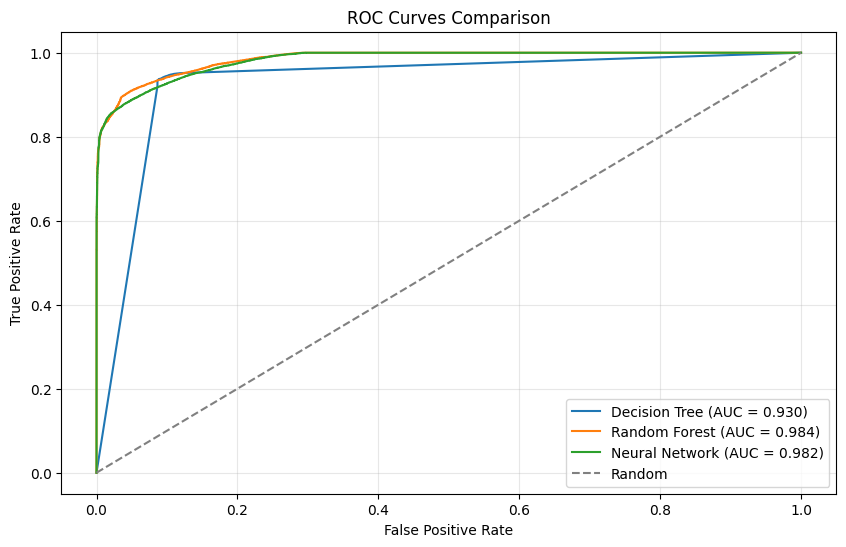

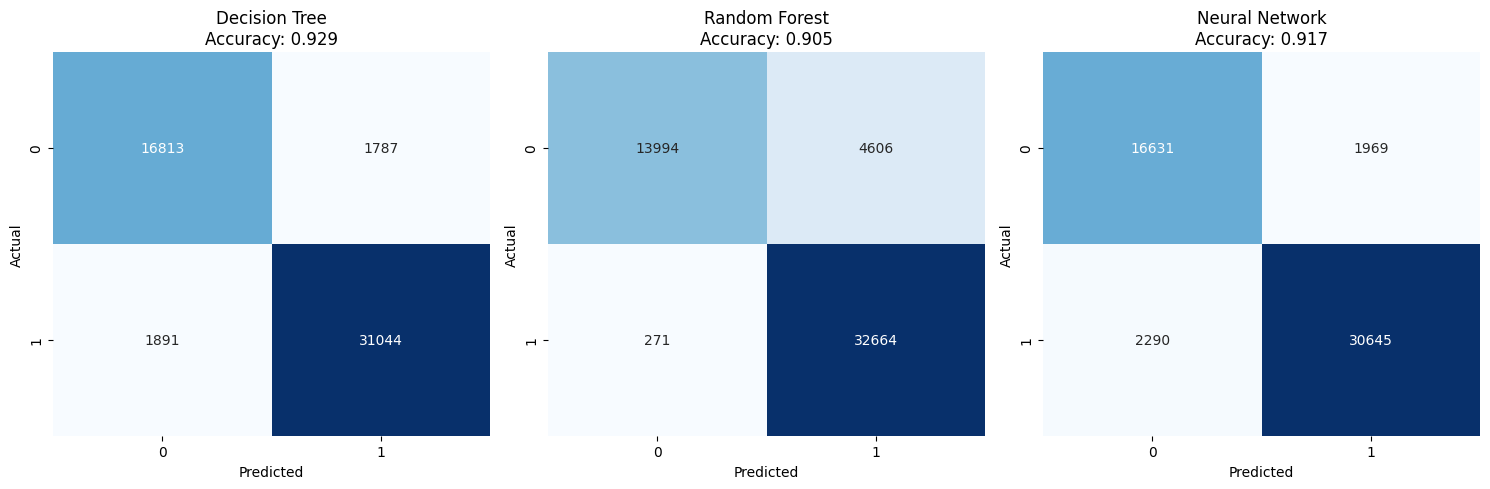

In [20]:
# Initialize and preprocess
comparator = NetworkIntrusionModelComparator()
comparator.preprocess_data(df)  # Your DataFrame `df`

# Train all models
comparator.train_models()

# Evaluate metrics
print(comparator.evaluate_models())

# Visualize results
comparator.plot_roc_curves()
comparator.plot_confusion_matrices()
comparator.plot_learning_curves()  

<module 'matplotlib.pyplot' from 'C:\\Users\\hp\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

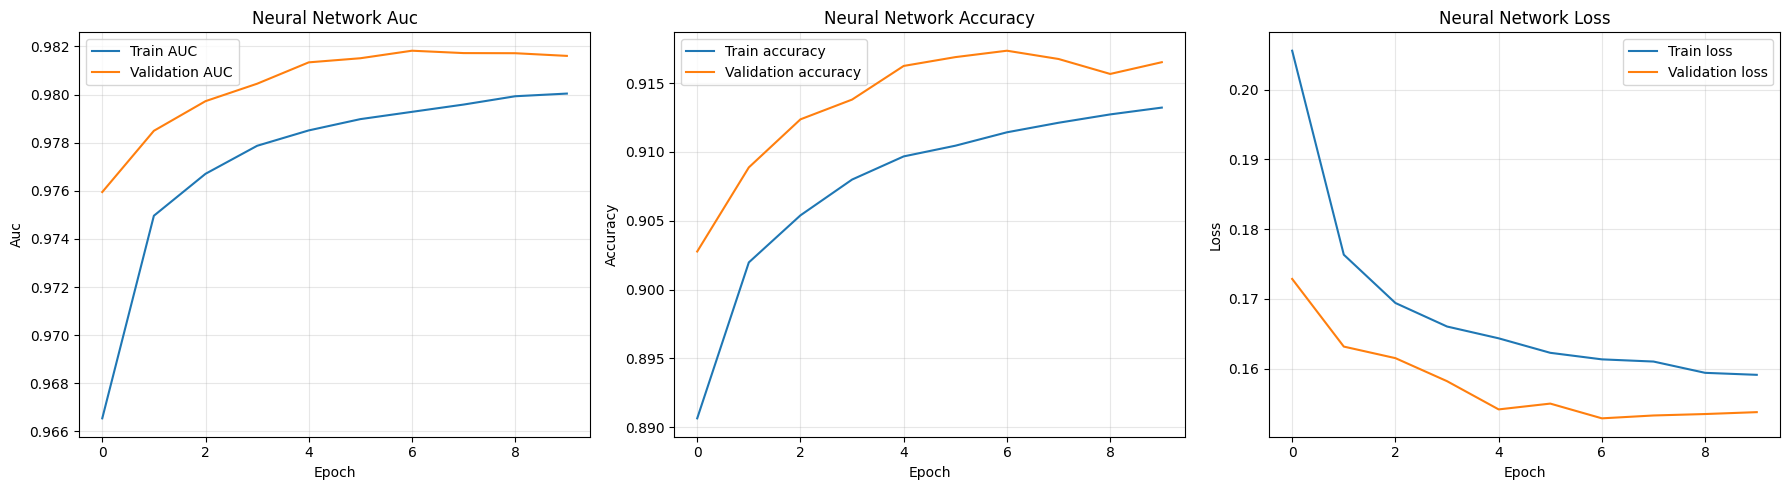

In [22]:
comparator.plot_learning_curves()  